In [9]:
import plotly.express as px

In [4]:
%%bigquery auto_claim_volume --use_rest_api
SELECT
    company,
    coverage,
    reported_date,
    SUM(exposure_reported) reported_count
FROM
    `gcp-ent-datalake-prod.trns_claims_ent_data_visible.vw_enterprise_scorecard_financials_business`
WHERE
    line_of_business = 'Personal Auto Line'
    AND record_only = 'N'
    AND coverage IS NOT NULL
    AND company IS NOT null
    AND coverage NOT IN (
        'Unmapped',
        'Property Damage Liability - Rental',
        'Rental Reimbursement',
        'Boat',
        'Emergency Road Service',
        'Comprehensive - Glass'
    )
    AND EXTRACT(year FROM reported_date) >= 2017
GROUP BY 1, 2, 3
ORDER BY 1, 2, 3

Query is running:   0%|          |

Downloading:   0%|          |

In [6]:
auto_claim_volume.head()

company       coverage reported_date  reported_count
0   Amfam  Bodily Injury    2017-01-01              19
1   Amfam  Bodily Injury    2017-01-02              66
2   Amfam  Bodily Injury    2017-01-03             168
3   Amfam  Bodily Injury    2017-01-04             131
4   Amfam  Bodily Injury    2017-01-05             135

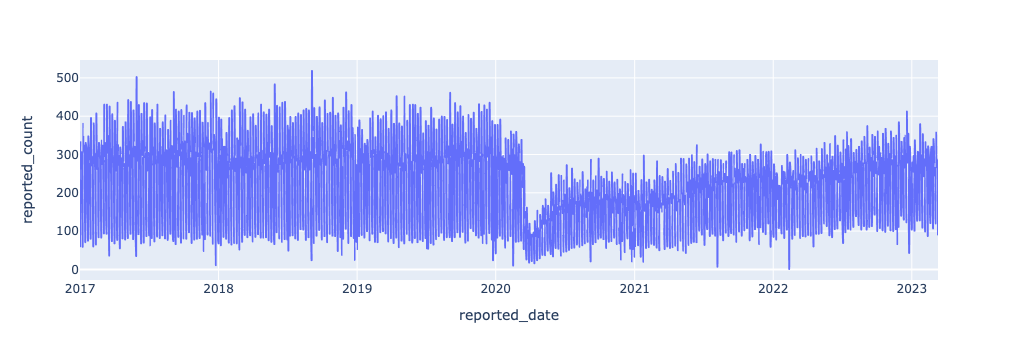

In [11]:
mask = (auto_claim_volume.company=="Connect") & (auto_claim_volume.coverage=='Collision')
fig = px.line(auto_claim_volume[mask], x='reported_date', y="reported_count")
fig.show()

In [1]:
%%bigquery --use_rest_api
CREATE OR REPLACE MODEL bjacob_mw_dataset.auto_claim_volume_company_coverage
OPTIONS
    (model_type = 'ARIMA_PLUS',
     time_series_timestamp_col = 'reported_date',
     time_series_data_col = 'reported_count',
     time_series_id_col = ['company', 'coverage'],
     auto_arima = TRUE,
     auto_arima_max_order = 5, # Max = 5.
     data_frequency = 'AUTO_FREQUENCY',
     decompose_time_series = TRUE,
     holiday_region='US'
    ) AS
SELECT
    company,
    coverage,
    reported_date,
    SUM(exposure_reported) reported_count
FROM
    `gcp-ent-datalake-prod.trns_claims_ent_data_visible.vw_enterprise_scorecard_financials_business`
WHERE
    line_of_business = 'Personal Auto Line'
    AND record_only = 'N'
    AND coverage IS NOT NULL
    and company IS NOT null
    AND coverage NOT IN (
        'Unmapped',
        'Property Damage Liability - Rental',
        'Rental Reimbursement',
        'Boat',
        'Emergency Road Service',
        'Comprehensive - Glass'
    )
    AND EXTRACT(year FROM reported_date) >= 2017
GROUP BY 1, 2, 3
ORDER BY 1, 2, 3

Query is running:   0%|          |

In [12]:
%%bigquery arima_evaluate --use_rest_api
SELECT
 *
FROM
 ML.ARIMA_EVALUATE(MODEL bjacob_mw_dataset.auto_claim_volume_company_coverage)

Query is running:   0%|          |

Downloading:   0%|          |

In [13]:
arima_evaluate.head()

company       coverage  non_seasonal_p  non_seasonal_d  non_seasonal_q  \
0   Amfam  Bodily Injury               2               1               3   
1   Amfam      Collision               0               1               5   
2   Amfam  Comprehensive               3               1               1   
3   Amfam        Med Pay               2               1               3   
4   Amfam            PIP               0               1               5   

   has_drift  log_likelihood           AIC     variance  seasonal_periods  \
0      False    -8707.013316  17426.026632   130.194106  [WEEKLY, YEARLY]   
1      False   -11992.452063  23996.904126  2376.686447  [WEEKLY, YEARLY]   
2      False   -12035.396173  24080.792345  2470.431012  [WEEKLY, YEARLY]   
3       True    -8250.095277  16514.190553    86.488161  [WEEKLY, YEARLY]   
4      False    -7867.702061  15747.404121    61.700068  [WEEKLY, YEARLY]   

   has_holiday_effect  has_spikes_and_dips  has_step_changes error_message  
0                True                 True              True                
1                True                False              True                
2                True                 True              True                
3                True                False              True                
4                True                False              True

In [20]:
%%bigquery arima_coefficients --use_rest_api
SELECT
 *
FROM
 ML.ARIMA_COEFFICIENTS(MODEL bjacob_mw_dataset.auto_claim_volume_company_coverage)

Query is running:   0%|          |

Downloading:   0%|          |

In [24]:
arima_coefficients

company                   coverage  \
0         Amfam              Bodily Injury   
1         Amfam                  Collision   
2         Amfam              Comprehensive   
3         Amfam                    Med Pay   
4         Amfam                        PIP   
5         Amfam  Property Damage Liability   
6         Amfam                     UM/UIM   
7       Connect              Bodily Injury   
8       Connect                  Collision   
9       Connect              Comprehensive   
10      Connect                    Med Pay   
11      Connect                        PIP   
12      Connect  Property Damage Liability   
13      Connect                     UM/UIM   
14          MSA              Bodily Injury   
15          MSA                  Collision   
16          MSA              Comprehensive   
17          MSA                    Med Pay   
18          MSA                        PIP   
19          MSA  Property Damage Liability   
20          MSA                     UM/UIM   
21      Midvale              Bodily Injury   
22      Midvale                  Collision   
23      Midvale              Comprehensive   
24      Midvale                    Med Pay   
25      Midvale                        PIP   
26      Midvale  Property Damage Liability   
27      Midvale                     UM/UIM   
28  the General              Bodily Injury   
29  the General                  Collision   
30  the General              Comprehensive   
31  the General                    Med Pay   
32  the General                        PIP   
33  the General  Property Damage Liability   
34  the General                     UM/UIM   

                                      ar_coefficients  \
0         [-0.39495092577566937, -0.7228384315025225]   
1                                                  []   
2   [0.4060834983316491, 0.08969721083554019, 0.09...   
3         [-0.47632441455683283, -0.6987127464431983]   
4                                                  []   
5                                                  []   
6                                                  []   
7                                                  []   
8                                                  []   
9                                                  []   
10                                                 []   
11         [-0.43082836288919024, -0.674905346552758]   
12                                                 []   
13        [-0.33660354519144137, -0.6422825785639914]   
14                                                 []   
15          [-0.5567958972736428, -0.756140875161019]   
16                                                 []   
17                                                 []   
18         [-0.21837196088637562, 0.5751848830423311]   
19                                                 []   
20                               [0.3404490358092641]   
21  [2.229334990071469, -2.6318282910512965, 2.120...   
22                                                 []   
23                              [0.05273666537546624]   
24                               [0.7886142737017563]   
25           [0.3439920202533533, 0.5693236542201731]   
26                                                 []   
27                               [0.5549113695250191]   
28                                                 []   
29                                                 []   
30                                                 []   
31                                                 []   
32                                                 []   
33                                                 []   
34         [-0.4546080305422023, -0.6481097976741939]   

                                      ma_coefficients  intercept_or_drift  
0   [-0.5015965016324712, 0.578991714166759, -0.89...            0.000000  
1   [-1.0867996833129512, 0.23238603284330162, 0.2...            0.000000  
2                               [-0.9775253012594162]            0.000

In [25]:
%%bigquery forecast_prediction_intervals --use_rest_api
SELECT
 *
FROM
 ML.FORECAST(MODEL bjacob_mw_dataset.auto_claim_volume_company_coverage,
             STRUCT(30 AS horizon, 0.9 AS confidence_level))

Query is running:   0%|          |

Downloading:   0%|          |

In [27]:
forecast_prediction_intervals.head()

company       coverage        forecast_timestamp  forecast_value  \
0   Amfam  Bodily Injury 2023-03-11 00:00:00+00:00       12.812443   
1   Amfam  Bodily Injury 2023-03-12 00:00:00+00:00        3.892619   
2   Amfam  Bodily Injury 2023-03-13 00:00:00+00:00       64.398931   
3   Amfam  Bodily Injury 2023-03-14 00:00:00+00:00       46.729263   
4   Amfam  Bodily Injury 2023-03-15 00:00:00+00:00       40.730980   

   standard_error  confidence_level  prediction_interval_lower_bound  \
0       11.410263               0.9                        -5.935431   
1       11.471159               0.9                       -14.955313   
2       12.016632               0.9                        44.654750   
3       12.018952               0.9                        26.981269   
4       12.027876               0.9                        20.968324   

   prediction_interval_upper_bound  confidence_interval_lower_bound  \
0                        31.560318                        -5.935431   
1                        22.740550                       -14.955313   
2                        84.143113                        44.654750   
3                        66.477256                        26.981269   
4                        60.493637                        20.968324   

   confidence_interval_upper_bound  
0                        31.560318  
1                        22.740550  
2                        84.143113  
3                        66.477256  
4                        60.493637

In [33]:
mask = (forecast_prediction_intervals.company=="Connect") & (forecast_prediction_intervals.coverage=='Collision')
forecast_prediction_intervals[mask].head()

company   coverage        forecast_timestamp  forecast_value  \
240  Connect  Collision 2023-03-12 00:00:00+00:00       88.025997   
241  Connect  Collision 2023-03-13 00:00:00+00:00      317.928769   
242  Connect  Collision 2023-03-14 00:00:00+00:00      282.550099   
243  Connect  Collision 2023-03-15 00:00:00+00:00      264.525996   
244  Connect  Collision 2023-03-16 00:00:00+00:00      264.385934   

     standard_error  confidence_level  prediction_interval_lower_bound  \
240       16.437880               0.9                        61.017391   
241       16.495945               0.9                       290.824756   
242       16.637477               0.9                       255.213540   
243       18.646828               0.9                       233.887931   
244       20.405557               0.9                       230.858152   

     prediction_interval_upper_bound  confidence_interval_lower_bound  \
240                       115.034603                        61.017391   
241                       345.032781                       290.824756   
242                       309.886658                       255.213540   
243                       295.164062                       233.887931   
244                       297.913716                       230.858152   

     confidence_interval_upper_bound  
240                       115.034603  
241                       345.032781  
242                       309.886658  
243                       295.164062  
244                       297.913716

In [35]:
columns=forecast_prediction_intervals.columns.drop(['confidence_interval_lower_bound', # soon to be deprecated
                                                    'confidence_interval_upper_bound', # soon to be deprecated
                                                    'standard_error', 'confidence_level',
                                                    'company', 'coverage'])

fig = px.line(forecast_prediction_intervals[mask], x='forecast_timestamp', y=columns)
fig.show()

In [38]:
%%bigquery explain_forecast --use_rest_api
SELECT
 *
FROM
 ML.EXPLAIN_FORECAST(MODEL bjacob_mw_dataset.auto_claim_volume_company_coverage,
                     STRUCT(30 AS horizon, 0.9 AS confidence_level))

Query is running:   0%|          |

Downloading:   0%|          |

In [39]:
explain_forecast.head()

company       coverage     time_series_timestamp time_series_type  \
0   Amfam  Bodily Injury 2017-01-01 00:00:00+00:00          history   
1   Amfam  Bodily Injury 2017-01-02 00:00:00+00:00          history   
2   Amfam  Bodily Injury 2017-01-03 00:00:00+00:00          history   
3   Amfam  Bodily Injury 2017-01-04 00:00:00+00:00          history   
4   Amfam  Bodily Injury 2017-01-05 00:00:00+00:00          history   

   time_series_data  time_series_adjusted_data  standard_error  \
0              19.0                 -14.795710       11.410263   
1              66.0                 131.434654       11.410263   
2             168.0                 116.978548       11.410263   
3             131.0                  85.123821       11.410263   
4             135.0                  91.542032       11.410263   

   confidence_level  prediction_interval_lower_bound  \
0               NaN                              NaN   
1               NaN                              NaN   
2               NaN                              NaN   
3               NaN                              NaN   
4               NaN                              NaN   

   prediction_interval_upper_bound       trend  seasonal_period_yearly  \
0                              NaN    0.000000              -71.747718   
1                              NaN  118.331261              -10.285192   
2                              NaN   75.113765                3.839201   
3                              NaN   64.351314                7.022841   
4                              NaN   78.907950               -1.906859   

   seasonal_period_quarterly  seasonal_period_monthly  seasonal_period_weekly  \
0                        NaN                      NaN              -61.379393   
1                        NaN                      NaN               23.388585   
2                        NaN                      NaN               38.025583   
3                        NaN                      NaN               13.749665   
4                        NaN                      NaN               14.540941   

   seasonal_period_daily  holiday_effect  spikes_and_dips  step_changes  
0                    NaN             0.0              0.0      33.79571  
1                    NaN             0.0              0.0      33.79571  
2                    NaN             0.0              0.0      33.79571  
3                    NaN             0.0              0.0      33.79571  
4                    NaN             0.0              0.0      33.79571

In [40]:
mask = (explain_forecast.company=="Connect") & (explain_forecast.coverage=='Collision')
explain_forecast[mask].head()

company   coverage     time_series_timestamp time_series_type  \
18325  Connect  Collision 2017-01-01 00:00:00+00:00          history   
18326  Connect  Collision 2017-01-02 00:00:00+00:00          history   
18327  Connect  Collision 2017-01-03 00:00:00+00:00          history   
18328  Connect  Collision 2017-01-04 00:00:00+00:00          history   
18329  Connect  Collision 2017-01-05 00:00:00+00:00          history   

       time_series_data  time_series_adjusted_data  standard_error  \
18325              60.0                 -52.993414        16.43788   
18326             234.0                 348.887296        16.43788   
18327             332.0                 214.081326        16.43788   
18328             263.0                 222.929659        16.43788   
18329             296.0                 177.082505        16.43788   

       confidence_level  prediction_interval_lower_bound  \
18325               NaN                              NaN   
18326               NaN                              NaN   
18327               NaN                              NaN   
18328               NaN                              NaN   
18329               NaN                              NaN   

       prediction_interval_upper_bound       trend  seasonal_period_yearly  \
18325                              NaN    0.000000             -166.232189   
18326                              NaN  271.663817              -11.658335   
18327                              NaN  154.504825               -9.309673   
18328                              NaN  188.028302              -13.531009   
18329                              NaN  154.739382               -3.252876   

       seasonal_period_quarterly  seasonal_period_monthly  \
18325                        NaN                      NaN   
18326                        NaN                      NaN   
18327                        NaN                      NaN   
18328                        NaN                      NaN   
18329                        NaN                      NaN   

       seasonal_period_weekly  seasonal_period_daily  holiday_effect  \
18325             -158.381044                    NaN             0.0   
18326               88.881813                    NaN             0.0   
18327               68.886174                    NaN             0.0   
18328               48.432367                    NaN             0.0   
18329               25.595999                    NaN             0.0   

       spikes_and_dips  step_changes  
18325              NaN    112.993414  
18326              NaN    112.993414  
18327              NaN    112.993414  
18328              NaN    112.993414  
18329              NaN    112.993414

In [41]:
columns=['time_series_data', 
         # 'prediction_interval_lower_bound',
         # 'prediction_interval_upper_bound', 
         'trend', 'seasonal_period_weekly', 'step_changes']

fig = px.line(explain_forecast[mask], x='time_series_timestamp', y=columns)
fig.show()

In [53]:
%%bigquery --use_rest_api
select
    company,
    coverage,
    forecast_timestamp AS timestamp,
    NULL AS history_value,
    forecast_value,
    prediction_interval_lower_bound,
    prediction_interval_upper_bound
FROM
  ML.FORECAST(MODEL bjacob_mw_dataset.auto_claim_volume_company_coverage,
             STRUCT(30 AS horizon, 0.9 AS confidence_level))

Query is running:   0%|          |

Downloading:   0%|          |

company       coverage                 timestamp  history_value  \
0           Amfam  Bodily Injury 2023-03-11 00:00:00+00:00           <NA>   
1           Amfam  Bodily Injury 2023-03-12 00:00:00+00:00           <NA>   
2           Amfam  Bodily Injury 2023-03-13 00:00:00+00:00           <NA>   
3           Amfam  Bodily Injury 2023-03-14 00:00:00+00:00           <NA>   
4           Amfam  Bodily Injury 2023-03-15 00:00:00+00:00           <NA>   
...           ...            ...                       ...            ...   
1045  the General         UM/UIM 2023-04-04 00:00:00+00:00           <NA>   
1046  the General         UM/UIM 2023-04-05 00:00:00+00:00           <NA>   
1047  the General         UM/UIM 2023-04-06 00:00:00+00:00           <NA>   
1048  the General         UM/UIM 2023-04-07 00:00:00+00:00           <NA>   
1049  the General         UM/UIM 2023-04-08 00:00:00+00:00           <NA>   

      forecast_value  prediction_interval_lower_bound  \
0          12.812443                        -5.935431   
1           3.892619                       -14.955313   
2          64.398931                        44.654750   
3          46.729263                        26.981269   
4          40.730980                        20.968324   
...              ...                              ...   
1045        7.700448                         0.468607   
1046        6.907430                        -0.338842   
1047        7.040404                        -0.219276   
1048        6.369466                        -0.904101   
1049        2.834199                        -4.453644   

      prediction_interval_upper_bound  
0                           31.560318  
1                           22.740550  
2                           84.143113  
3                           66.477256  
4                           60.493637  
...                               ...  
1045                        14.932289  
1046                        14.153702  
1047                        14.300085  
1048                        13.643034  
1049                        10.122042  

[1050 rows x 7 columns]

In [59]:
%%bigquery auto_claim_volume_forecast --use_rest_api
SELECT
    company,
    coverage,
    reported_date AS timestamp,
    reported_count AS history_value,
    NULL AS forecast_value,
    NULL AS prediction_interval_lower_bound,
    NULL AS prediction_interval_upper_bound
FROM
 (
    SELECT
        company,
        coverage,
        TIMESTAMP(reported_date) AS reported_date,
        SUM(exposure_reported) reported_count
    FROM
        `gcp-ent-datalake-prod.trns_claims_ent_data_visible.vw_enterprise_scorecard_financials_business`
    WHERE
        line_of_business = 'Personal Auto Line'
        AND record_only = 'N'
        AND company = 'Connect'
        AND coverage = 'Collision'
        AND EXTRACT(year FROM reported_date) >= 2017
    GROUP BY 1, 2, 3
    ORDER BY 1, 2, 3
 )
UNION ALL
(
    SELECT
        company,
        coverage,
        forecast_timestamp AS timestamp,
        NULL AS history_value,
        forecast_value,
        prediction_interval_lower_bound,
        prediction_interval_upper_bound
    FROM
      ML.FORECAST(MODEL bjacob_mw_dataset.auto_claim_volume_company_coverage,
                 STRUCT(30 AS horizon, 0.9 AS confidence_level))
    WHERE
        company = 'Connect'
        AND coverage = 'Collision'
)

Query is running:   0%|          |

Downloading:   0%|          |

In [60]:
auto_claim_volume_forecast.sort_values("timestamp", inplace=True)
auto_claim_volume_forecast.tail()

company   coverage                 timestamp  history_value  \
1253  Connect  Collision 2023-04-06 00:00:00+00:00           <NA>   
1254  Connect  Collision 2023-04-07 00:00:00+00:00           <NA>   
1255  Connect  Collision 2023-04-08 00:00:00+00:00           <NA>   
1256  Connect  Collision 2023-04-09 00:00:00+00:00           <NA>   
1257  Connect  Collision 2023-04-10 00:00:00+00:00           <NA>   

      forecast_value  prediction_interval_lower_bound  \
1253      242.501450                       207.438431   
1254      236.949758                       201.815306   
1255      126.087773                        90.882033   
1256       82.205956                        46.929072   
1257      287.336569                       251.988684   

      prediction_interval_upper_bound  
1253                       277.564468  
1254                       272.084210  
1255                       161.293513  
1256                       117.482840  
1257                       322.684455

In [62]:
columns=auto_claim_volume_forecast.columns.drop(['prediction_interval_lower_bound',
                                                 'prediction_interval_upper_bound',
                                                 'company', 'coverage'])

fig = px.line(auto_claim_volume_forecast, x='timestamp', y=columns)
fig.show()